In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [28]:
signal_trees = TreeIter(list(map(Tree,fc.eightb.accstudies_no_pu.signal_list)))
# signal_trees_pu = TreeIter(list(map(Tree,fc.eightb.accstudies.signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

In [29]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [30]:
dout = "preselections/"

tree = signal_trees[-2]
# tree_pu = signal_trees_pu[-2]

In [33]:
signal_trees.extend(kwargs=eightb.reco_all)
varinfo.clear()

In [35]:
quark_cuts = FilterSequence(*[ EventFilter(f'{quark}_cut',**{f'{quark}_recojet_pt_min':0}) for quark in eightb.quarklist ])
base_trees = quark_cuts.filter(signal_trees)

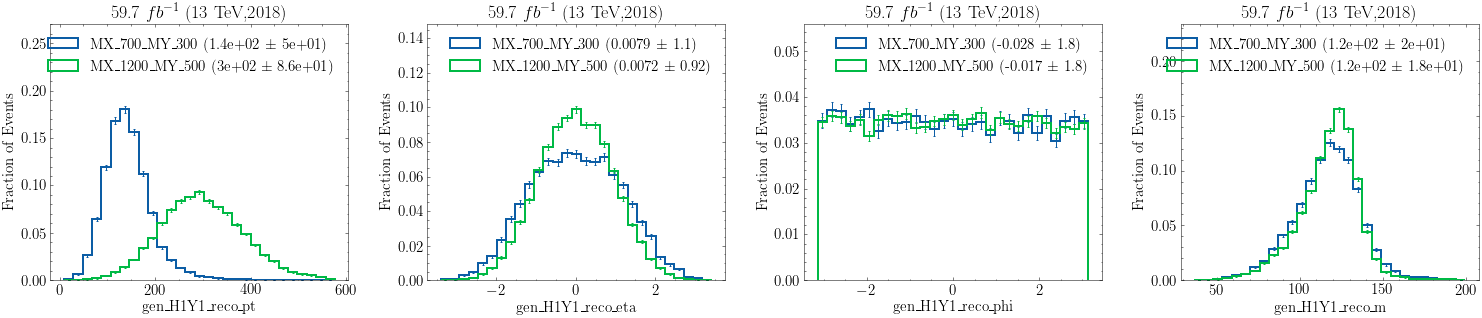

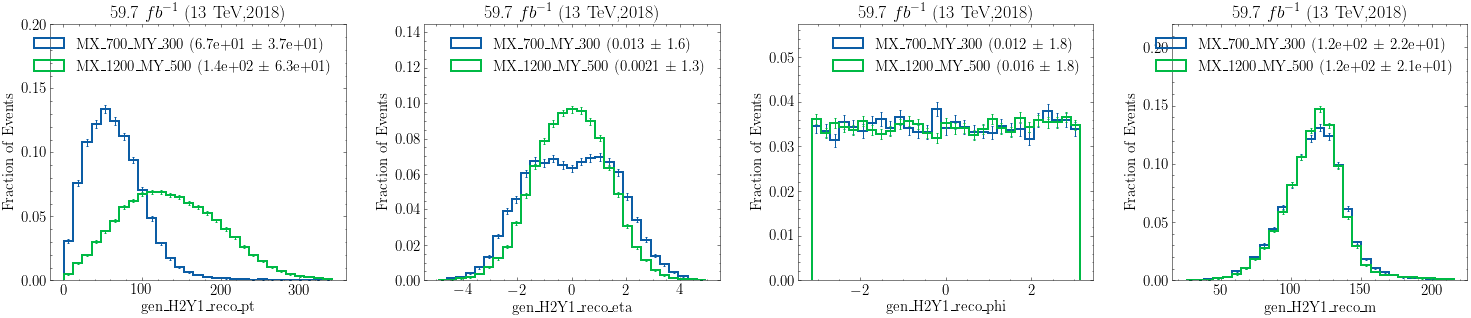

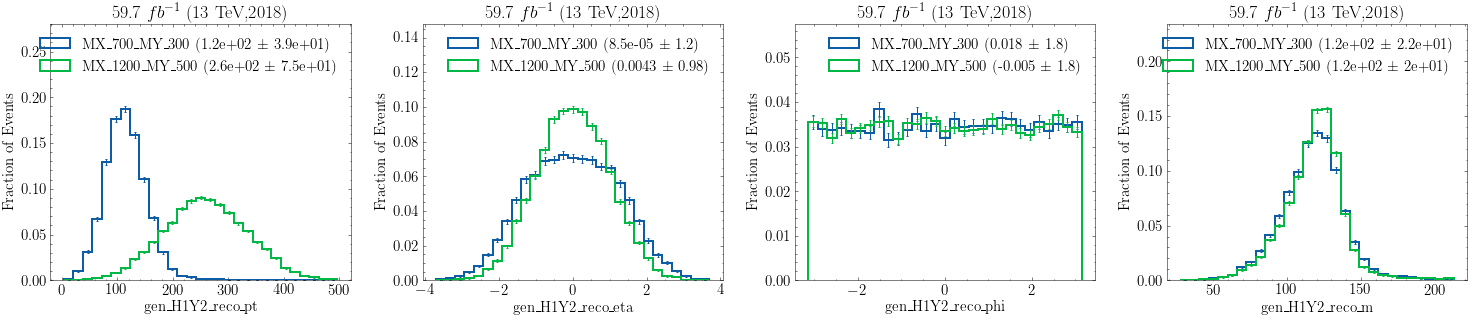

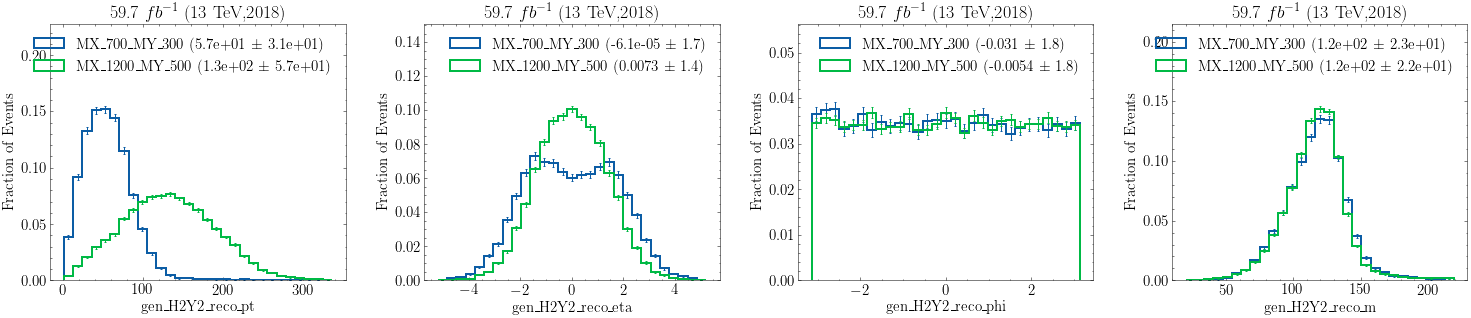

In [36]:
varlist = ['pt','eta','phi','m']

for higgs in eightb.higgslist:
    study.quick(
        base_trees[::7], 
        varlist=[f'{higgs}_reco_{var}' for var in varlist],
        s_colors=[None],
        dim=(-1,len(varlist)),
        s_label_stat='mean_stdv',
        yscale=(0,1.5),
        density=True
    )

In [37]:
quark_cuts = FilterSequence(*[ EventFilter(f'{quark}_cut',**{f'{quark}_recojet_pt_min':20}) for quark in eightb.quarklist ])
signal_trees = quark_cuts.filter(signal_trees)

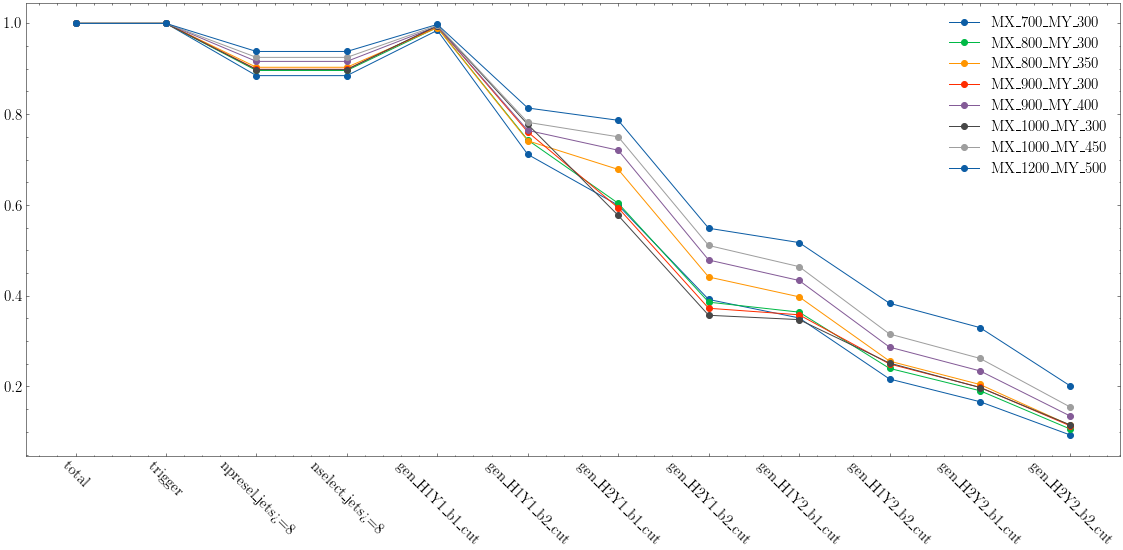

In [38]:
study.cutflow(signal_trees,s_colors=None,density=True,log=False)

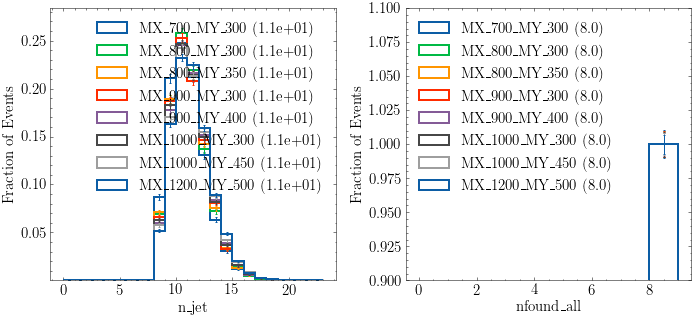

In [39]:
study.quick(
    signal_trees,
    varlist=['n_jet','nfound_all'],
    scale=False,
    s_colors=None,
    s_label_stat='mean',
    density=True,
)

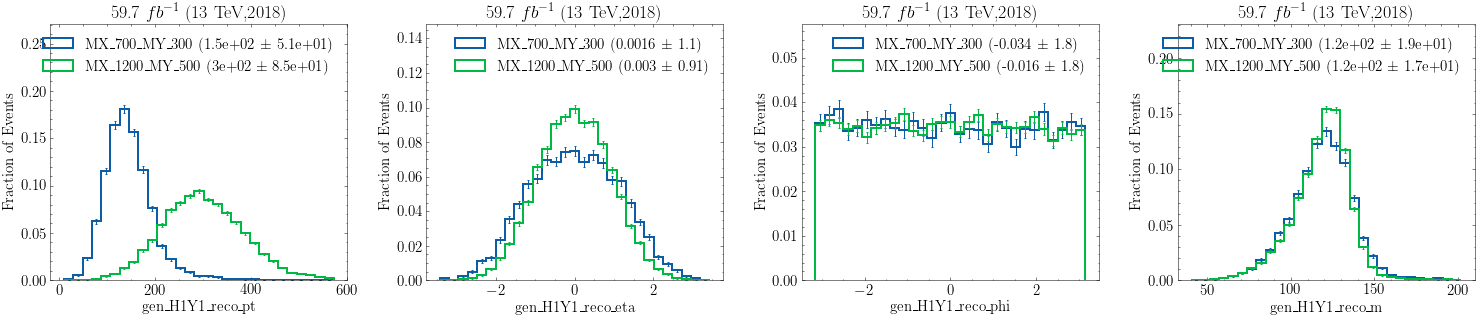

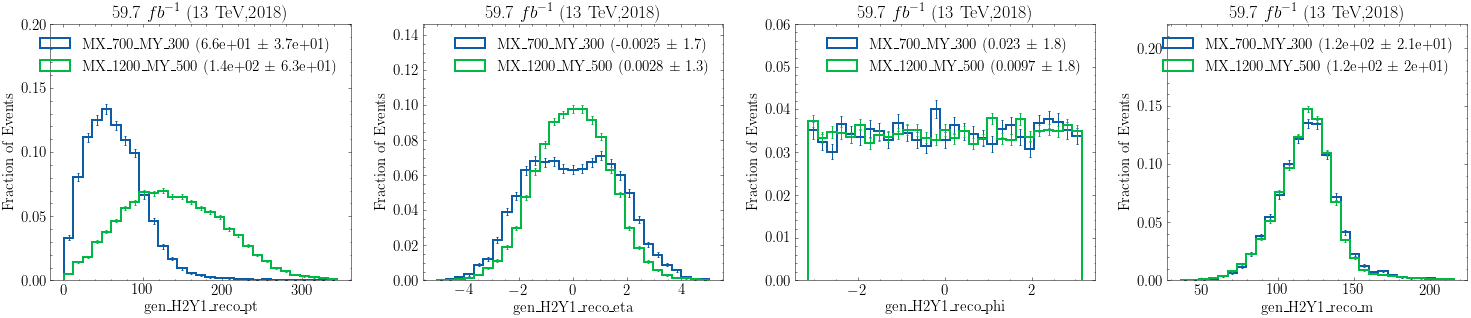

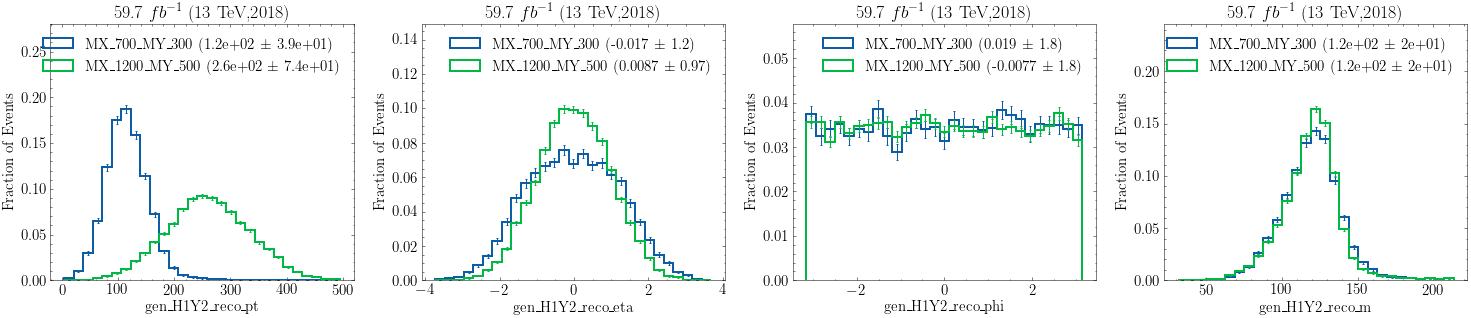

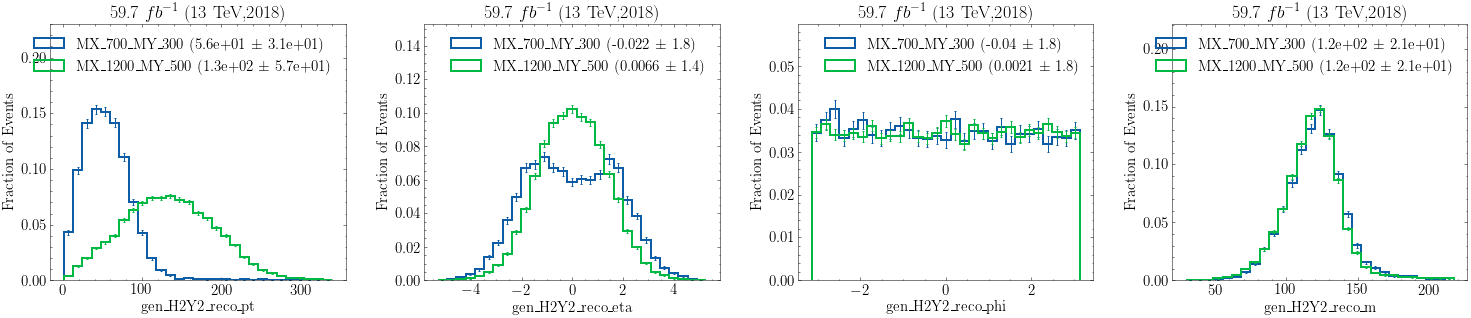

In [40]:
varlist = ['pt','eta','phi','m']

for higgs in eightb.higgslist:
    study.quick(
        signal_trees[::7], 
        varlist=[f'{higgs}_reco_{var}' for var in varlist],
        s_colors=[None],
        dim=(-1,len(varlist)),
        s_label_stat='mean_stdv',
        yscale=(0,1.5),
        density=True
    )

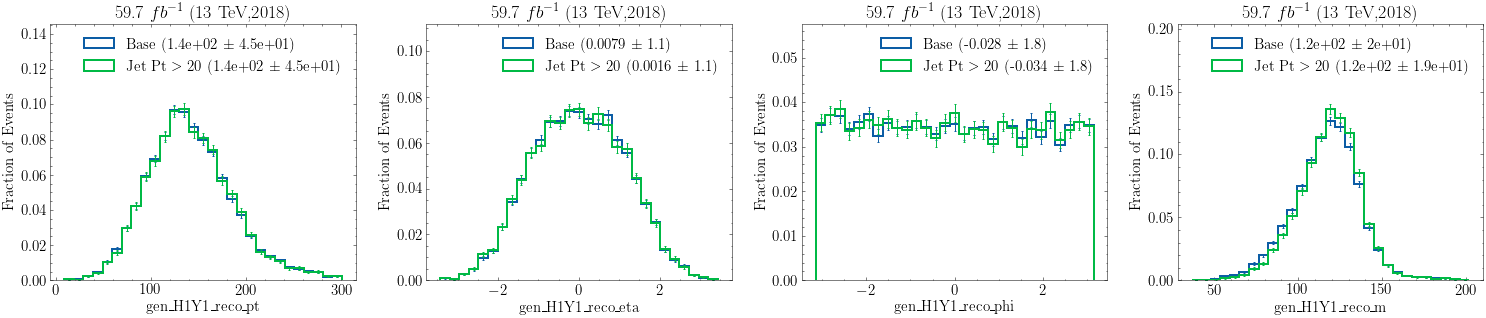

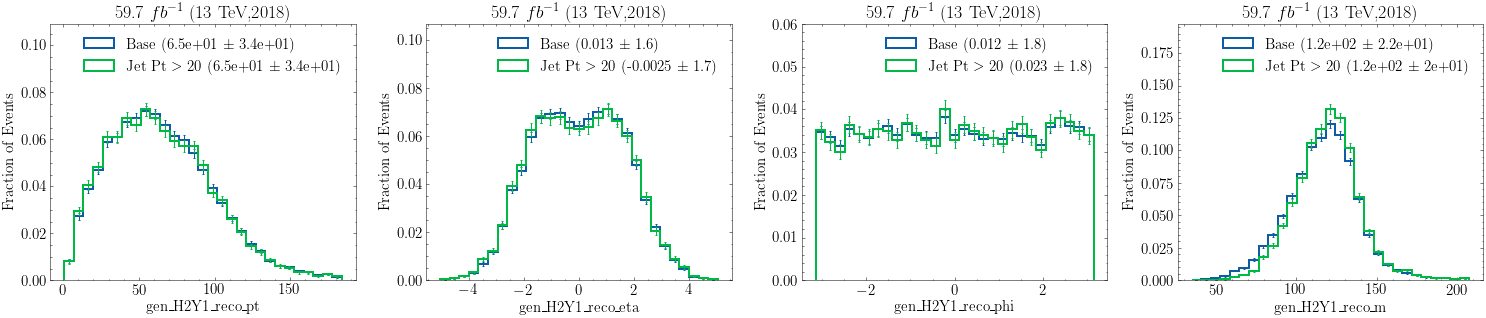

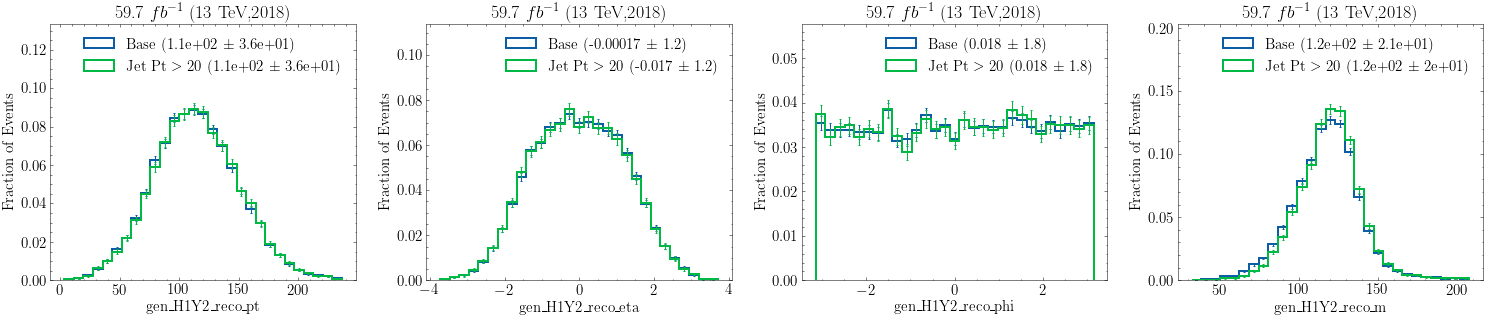

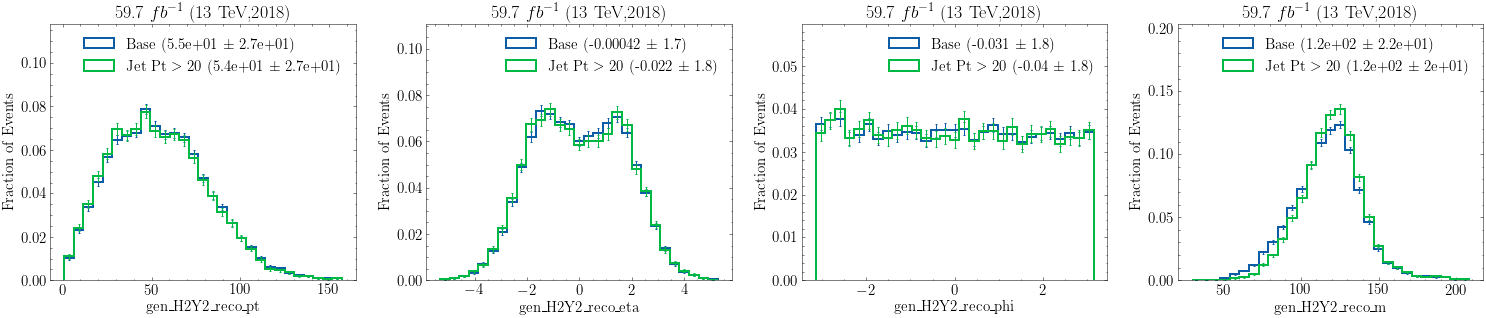

In [43]:
varlist = ['pt','eta','phi','m']

for higgs in eightb.higgslist:
    study.quick(
        [base_trees[0],signal_trees[0]], 
        varlist=[f'{higgs}_reco_{var}' for var in varlist],
        s_colors=[None],
        labels=['Base','Jet Pt $>$ 20'],
        dim=(-1,len(varlist)),
        s_label_stat='mean_stdv',
        density=True
    )